# Imports and data loading

In [1]:
import gtfparse
import os
import re
import numpy as np
import pandas as pd


import seaborn as sns
import glob
from tqdm import tqdm
from joblib import Parallel, delayed

from kmer_utils import get_encoded_kmer_hashvals

%load_ext autoreload
%autoreload 2

In [2]:
def format_integer(integer):
    return f'{integer:,d}'

def print_shape(df):
    height, width = df.shape
    df

In [3]:
outdir = '/Users/olgabot/botryllus/adhoc-analysis/2022-apr--gather-botryllus-in-human-mouse-with-kmers/'
# ! mkdir $outdir

In [4]:
%%time

mhc_parquet =  os.path.join(outdir, "botryllus_gather_mouse_human_results_mhc.parquet")


gather_results_mhc = pd.read_parquet(mhc_parquet
)
print((format_integer(x) for x in gather_results_mhc.shape))
gather_results_mhc.head()

<generator object <genexpr> at 0x1b638a5e0>
CPU times: user 29.4 s, sys: 33.4 s, total: 1min 2s
Wall time: 1min 3s


,i_query,kmer_query,kmer_hp,hashval,name_query,i_found,kmer_found,name_found,n_kmers,intersect_bp,containment,symbol,species,found_i,homolog_group,genomic_coord,all_homologs_found,transcript_id
0,623,DVNLRDQQGKSPIFYAEEQNNLDV,phphpppphpphhhhhppppphph,9053272763448756255,g22187.t1 frame:1,30,RGHLCRTRPTDLVFVVDSSRSVRP,ENST00000373765.5 gene_id=ENSG00000162510.6;tr...,4,20,0.023529,MATN1,human,0,MATN1---Matn1,Chr1:30711277-30723585(-),True,ENST00000373765.5
1,624,VNLRDQQGKSPIFYAEEQNNLDVM,hphpppphpphhhhhppppphphh,1654375679729437405,g22187.t1 frame:1,31,GHLCRTRPTDLVFVVDSSRSVRPV,ENST00000373765.5 gene_id=ENSG00000162510.6;tr...,4,20,0.023529,MATN1,human,0,MATN1---Matn1,Chr1:30711277-30723585(-),True,ENST00000373765.5
2,625,NLRDQQGKSPIFYAEEQNNLDVMK,phpppphpphhhhhppppphphhp,2361844746549016494,g22187.t1 frame:1,32,HLCRTRPTDLVFVVDSSRSVRPVE,ENST00000373765.5 gene_id=ENSG00000162510.6;tr...,4,20,0.023529,MATN1,human,0,MATN1---Matn1,Chr1:30711277-30723585(-),True,ENST00000373765.5
3,626,LRDQQGKSPIFYAEEQNNLDVMKY,hpppphpphhhhhppppphphhph,8601332297558688433,g22187.t1 frame:1,33,LCRTRPTDLVFVVDSSRSVRPVEF,ENST00000373765.5 gene_id=ENSG00000162510.6;tr...,4,20,0.023529,MATN1,human,0,MATN1---Matn1,Chr1:30711277-30723585(-),True,ENST00000373765.5
4,308,GKEKGTKKSPEIADDVSDNDKADA,hppphpppphphhpphppppphph,4814295539498208365,g22187.t1 frame:1,265,INKRLSKSSATLWNSPSRNRSLQL,ENST00000474796.2 gene_id=ENSG00000116871.16;t...,7,35,0.010204,MAP7D1,human,1,MAP7D1---Map7d1,Chr1:36155965-36180849(+),True,ENST00000474796.2


### What does BHF match to?

In [23]:
gather_results_mhc.query('name_query == "BHF"')

,i_query,kmer_query,kmer_hp,hashval,name_query,i_found,kmer_found,name_found,n_kmers,intersect_bp,containment,symbol,species,found_i,homolog_group,genomic_coord,all_homologs_found


/Users/olgabot/opt/miniconda3/envs/botryllus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='homolog_group', ylabel='Density'>

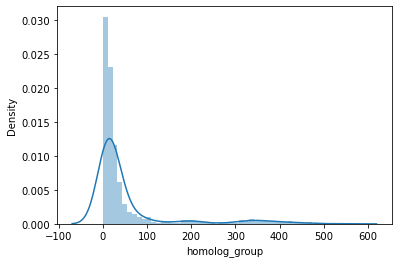

In [21]:
sns.distplot(gather_results_mhc.groupby('name_query').homolog_group.nunique())

In [17]:
print([format_integer(x) for x in gather_results_mhc.shape])


['14,353,955', '17']


In [12]:
print(f'{14353955:,d}')

14,353,955


In [4]:
gather_results_mhc.groupby('name_query').all_homologs_found.sum()

name_query
g10002.t1 frame:1      283
g1005.t1 frame:1       106
g10097.t1 frame:1        0
g10107.t1 frame:1       57
g10108.t1 frame:1    60564
                     ...  
g9842.t1 frame:1       141
g9843.t1 frame:1        20
g994.t1 frame:1        104
g9944.t1 frame:1        45
mFuHC                 1024
Name: all_homologs_found, Length: 1314, dtype: object

In [13]:
%%time
both_homologs = gather_results_mhc.groupby(["name_query", "homolog_group"]).filter(
    lambda x: x.all_homologs_found.sum() > 0
)
print(both_homologs.shape)
both_homologs.head()

(11723358, 17)
CPU times: user 19 s, sys: 2.41 s, total: 21.4 s
Wall time: 22.1 s


,i_query,kmer_query,kmer_hp,hashval,name_query,i_found,kmer_found,name_found,n_kmers,intersect_bp,containment,symbol,species,found_i,homolog_group,genomic_coord,all_homologs_found
42,133,ILAECEKKQKKSGEQQSTKKGKQN,hhhppppppppphppppppphppp,15018598761705965234,g3710.t1 frame:1,547,PAGDEEEEEEEELSSSCEEEGEED,ENST00000376621.8 gene_id=ENSG00000204590.13;t...,7,35,0.02521,GNL1,human,7,GNL1---Gnl1,Chr6:30541377-30557594(-),True
43,134,LAECEKKQKKSGEQQSTKKGKQNR,hhppppppppphppppppphpppp,12562551768375708943,g3710.t1 frame:1,548,AGDEEEEEEEELSSSCEEEGEEDR,ENST00000376621.8 gene_id=ENSG00000204590.13;t...,7,35,0.02521,GNL1,human,7,GNL1---Gnl1,Chr6:30541377-30557594(-),True
44,135,AECEKKQKKSGEQQSTKKGKQNRE,hppppppppphppppppphppppp,865309860413608026,g3710.t1 frame:1,549,GDEEEEEEEELSSSCEEEGEEDRD,ENST00000376621.8 gene_id=ENSG00000204590.13;t...,7,35,0.02521,GNL1,human,7,GNL1---Gnl1,Chr6:30541377-30557594(-),True
45,136,ECEKKQKKSGEQQSTKKGKQNREP,ppppppppphppppppphppppph,2819077766837459866,g3710.t1 frame:1,550,DEEEEEEEELSSSCEEEGEEDRDA,ENST00000376621.8 gene_id=ENSG00000204590.13;t...,7,35,0.02521,GNL1,human,7,GNL1---Gnl1,Chr6:30541377-30557594(-),True
46,137,CEKKQKKSGEQQSTKKGKQNREPE,pppppppphppppppphppppphp,15048812499418908875,g3710.t1 frame:1,551,EEEEEEEELSSSCEEEGEEDRDAD,ENST00000376621.8 gene_id=ENSG00000204590.13;t...,7,35,0.02521,GNL1,human,7,GNL1---Gnl1,Chr6:30541377-30557594(-),True


### How many matches per botryllus gene

In [18]:
both_homologs.groupby('name_query').homolog_group.nunique()

name_query
g10002.t1 frame:1     14
g1005.t1 frame:1       6
g10107.t1 frame:1      3
g10108.t1 frame:1    162
g10118.t1 frame:1      1
                    ... 
g9842.t1 frame:1      11
g9843.t1 frame:1       3
g994.t1 frame:1        6
g9944.t1 frame:1       4
mFuHC                 26
Name: homolog_group, Length: 1215, dtype: int64

In [22]:
both_homologs.query('name_query == "BHF"')

,i_query,kmer_query,kmer_hp,hashval,name_query,i_found,kmer_found,name_found,n_kmers,intersect_bp,containment,symbol,species,found_i,homolog_group,genomic_coord,all_homologs_found


In [ ]:
gather_results_mhc